# Improving model performance with xfeat, RAPIDS and Optuna


## Introduction

Feature Engineering is the processing of transforming raw data into features that can represent the underlying patterns of the data better. They can help boost the accuracy by a great deal and improve the ability of the model to generalise on unseen data. Every data scientist knows the importance feature engineering. Spending some time thinking about how best to apply and combine the available features can be very meaningful. 

Hyper parameter Optimisation is another such process which can help complement a good model by tuning it's hyperparameters, which can have a tremendous impact on the accuracy of the model. The time and resources required for these processes are generally the reason they're overlooked. 

With xfeat, RAPIDS and Optuna - we aim to bridge these gaps and elevate the performance. 

## What is Optuna?
[Optuna](https://github.com/optuna/optuna) is a lightweight framework for automatic hyperparameter optimization. It provides a define-by-run API, which makes it easy to adapt to any already existing code that we have and enables high modularity and the flexibility to construct hyperparameter spaces dynamically. By simply wrapping the objective function with Optuna can help perform a parallel-distributed HPO search over a search space. As we'll see in this notebook.

## What is xfeat?
[xfeat](https://github.com/pfnet-research/xfeat) is a feature engineering & exploration library using GPUs and Optuna. It provides a scikit-learn-like API for feature engineering with support for Pandas, cuDF dataframes and cuPy arrays. 

## What is RAPIDS?
[RAPIDS](https://rapids.ai/about.html) framework  provides a library suite that can execute end-to-end data science pipelines entirely on GPUs.  The libraries in the framework include [cuDF](https://github.com/rapidsai/cudf) - a GPU Dataframe with pandas-like API, [cuML](https://github.com/rapidsai/cuml) - implement machine learning algorithms that provide a scikit-learn-like API and many more. You can learn more [here](https://github.com/rapidsai).

In this notebook, we'll show how one can use these tools together to develop and improve a machine learning model. We'll use Airlines dataset (20M rows) to predict if a flight will be delayed or not. We'll explore how to use Optuna with RAPIDS and the speedups that we can achieve with the integration of these, and to see the improvements with GPU speedups, we have included a pandas version to run on CPU. A table summarizing the results is available at the end of the notebook.

### Pre-requisites

You need to have the following libraries installed - 

- Optuna, plotly, kaleido

Run the following in a new cell to install these packages:

```
!pip install optuna
!pip install plotly
!pip install kaleido
```

- To install xfeat, follow the instructions from their [repository](https://github.com/pfnet-research/xfeat)

Restart the kernel after you've installed the packages and then run the notebook.

In [1]:
import time
import json
import requests
import logging

import numpy as np

import cupy
import cudf
import cuml
from cuml import LogisticRegression
from cuml.metrics import roc_auc_score
from cuml.preprocessing.model_selection import train_test_split


import optuna
from optuna.study import StudyDirection
from optuna.trial import TrialState
from optuna import type_checking

import xfeat
from xfeat.pipeline import Pipeline
from xfeat.num_encoder import SelectNumerical
from xfeat.selector import ChiSquareKBest
from xfeat.optuna_selector import KBestThresholdExplorer
from functools import partial

import sklearn
from sklearn.model_selection import KFold
import pandas as pd


from cuml.preprocessing.LabelEncoder import LabelEncoder
from cuml.preprocessing.TargetEncoder import TargetEncoder
from xfeat import ArithmeticCombinations, Pipeline, SelectNumerical

In [2]:
import time
from contextlib import contextmanager
# Helping time blocks of code
@contextmanager
def timed(txt):
    t0 = time.time()
    yield
    t1 = time.time()
    print("%32s time:  %8.5f" % (txt, t1 - t0))

### Feature Engineering

The following functions are defined to perform a few feature engineering tasks on the data. The `feature_engineering` function is called on the dataframe `df`, in this function we perform a simple Arithmetic Combinations on the numerical columns that adds two columns to create a new one. We specify the `operator` and `r` - r is used to indicate how many columns need to be combined.

Then we call `categorical_encoding` which converts the categorical columns to numerical ones and then performs `target_encoding`. Target Encoding replaces the value with the target mean. This is helpful in classification problem to boost the model accuracy. Find more resources at the end of the notebook.

You'll also notice we use `Pipeline` from xfeat to combine two or more feature engineering tasks together. This is useful to concatenate encoders sequentially.

Read more about Feature Encoding and Pipelining with xfeat [here](https://github.com/pfnet-research/xfeat/blob/master/_docs/feature_encoding.md).

In [3]:
def feature_engineering(df):
    """
    Perform feature engineering and return a new df with engineered features
    """
    df_train, df_test, y_train, y_test = train_test_split(df, TARGET_COL,random_state=np.random.seed(0),
                                                          shuffle=True)
 
    # Xfeat's internal fold mechanism creates RangeIndex references, so we need to do an index reset on our data frames.
    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    # Need to do this to ensure we are appropriately assigning the split values
    df_train[TARGET_COL] = y_train
    df_test[TARGET_COL] = y_test
    
    
    for col in CAT_COLS:
        out_col = f'{col}_TE'
        lbl_enc = LabelEncoder(handle_unknown='ignore')
        tar_enc = TargetEncoder(n_folds=5, smooth=TARGET_ENC_SMOOTH, split_method=TARGET_ENC_SPLIT)
        
        df_train[col] = lbl_enc.fit_transform(df_train[col])
        df_train[out_col] = tar_enc.fit_transform(df_train[col], df_train[TARGET_COL])
        
        df_test[out_col] = tar_enc.transform(df_test[col])
        df_test[col] = lbl_enc.transform(df_test[col]).fillna(0)
        del lbl_enc, tar_enc



    encoder = Pipeline([
                        SelectNumerical(),
                        ArithmeticCombinations(exclude_cols=[TARGET_COL],
                                               drop_origin=False,
                                               operator="+",
                                               r=2,
                                               output_suffix="_plus")
                    ])

    df_train = encoder.fit_transform(df_train)
    df_test = encoder.transform(df_test)
    df = cudf.concat([df_train, df_test], sort=False)

    return df

### Feature Selection and Hyper parameter Optimisation

Now that we have some new features, how do we know they are relevant for the task or represent anything meaningful? We use the feature selection process to do this. This helps in selection of a subset of features that are  most informative. This helps in simplifying the problem and ensures that we aren't overloading the system with unimportant features. Optuna provides a way to choose a `selector` which accepts a `Pipeline` object from xfeat. You can see in the `feature_selection` function we define a Pipeline that takes in an Explorer and a Selection Algorithm (`ChiSquareKBest`). We pass this to an Optuna Study object, along with an Objective function

Chi squared tests are used to test the independence of two events. For Feature Selection, we aim to select feature, which are highly dependent on the response. This way, we can get features that will best determine the outcome.

### Objective Function
The objective function will be the one we optimize in Optuna Study. Objective funciton tries out different values for the parameters that we are tuning and saving the results in `study.trials_dataframes()`.

Let's define the objective function for this HPO task by making use of the `train_and_eval()`. You can see that we simply choose a value for the parameters and call the `train_and_eval` method, making Optuna very easy to use in an existing workflow.

The objective remains constant over different samplers, which are built-in options in Optuna to enable the selection of different sampling algorithms that optuna provides. Some of the available ones include - GridSampler, RandomSampler, TPESampler, etc. We'll use TPESampler for this demo, but feel free to try different samplers to notice the chnages in performance.


### HPO Trials and Study
Optuna uses [study](https://optuna.readthedocs.io/en/stable/reference/study.html) and [trials](https://optuna.readthedocs.io/en/stable/reference/trial.html) to keep track of the HPO experiments. Put simply, a trial is a single call of the objective function while a set of trials make up a study. We will pick the optimal performing trial from a study to get the best parameters that were used in that run.

In [4]:
def train_and_eval(df, penalty='l2', C=1.0, l1_ratio=None, fit_intercept=True, selector=None):
    # Splitting data and prepping for selector fit
    X_train,  X_test, y_train, y_test = train_test_split(df,
                                                         TARGET_COL,
                                                         random_state=np.random.seed(0),
                                                         shuffle=True)

    # Xfeat's internal fold mechanism creates RangeIndex references, so we need to do an index reset on our data frames.

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    if selector:
        # For the selector, the label also needs to be in the DF
        X_train[TARGET_COL] = y_train
        X_test[TARGET_COL] = y_test

        X_train = selector.fit_transform(X_train)
        X_test = selector.transform(X_test)

    # Train and get accuracy
    classifier = LogisticRegression(penalty=penalty,
                                    C=C,
                                    l1_ratio=l1_ratio,
                                    fit_intercept=fit_intercept)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict_proba(X_test.values)[:, 1]
    y_pred = y_pred.astype(y_test.dtype)
    score = roc_auc_score(y_test, y_pred)

    return score, classifier


def objective(df, selector, trial):
    """
    Performs the training and evaluation of the set of parameters and subset of features using selector.
    """
    selector.set_trial(trial)
    
    # Select Params
    C = trial.suggest_uniform("C", 0 , 7.0)
    penalty = trial.suggest_categorical("penalty", ['l1', 'none', 'l2'])
    l1_ratio = trial.suggest_uniform("l1_ratio", 0 , 1.0)
    fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])
    
    score, _ = train_and_eval(df,
                           penalty=penalty,
                           C=C,
                           l1_ratio=l1_ratio,
                           fit_intercept=fit_intercept,
                           selector=selector)
    return score

def feature_selection(df, experiment_name):
    """
    Defines the Pipeline and performs the optuna opt
    """
    selector = Pipeline(
        [
            SelectNumerical(),
            KBestThresholdExplorer(ChiSquareKBest(target_col=TARGET_COL)),
        ]
    )


    study = optuna.create_study(direction="maximize")

    study.optimize(partial(objective, df, selector), n_trials=N_TRIALS)

    selector.from_trial(study.best_trial)
    selected_cols = selector.get_selected_cols()

    df_select = df[selected_cols]
    df_select[TARGET_COL] = df[TARGET_COL]

    params = study.best_params
    score, classifier = train_and_eval(df_select,
                  C=params['C'],
                  penalty=params['penalty'],
                  l1_ratio=params['l1_ratio'],
                  fit_intercept=params['fit_intercept'])

    return study, df_select.reset_index(drop=True), classifier, score

### Set Experiment Variables

Change the `INPUT_FILE` to correspond to the path in your local system and select the number of rows and trials to run the experiment for. 

NOTE: It is not recommended to run the CPU version for more than 100,000 rows. To avoid this, we set a glad `cpu_run` based on `N_ROWS`

In [5]:
INPUT_FILE = "/home/data/airline_data/airline_small.parquet"

N_ROWS = 10000000
N_TRIALS = 10

TARGET_ENC_SMOOTH = 0.001
TARGET_ENC_SPLIT = 'interleaved'

CAT_COLS = ["Dest", "Origin", "UniqueCarrier"]
TARGET_COL = "ArrDelayBinary"

## GPU Run

Now, let's run the RAPIDS version by first reading in the data as cudf DataFrames.

In [6]:
import time
start_time = time.time()

In [7]:
df_ = cudf.read_parquet(INPUT_FILE)[:N_ROWS]
# Can't handle nagative values, yet
df_ = df_.drop(["ActualElapsedTime"], axis=1)
print("Default performance: ", train_and_eval(df_)[0])

df_.head()

Default performance:  0.5720653533935547


,ArrDelayBinary,Year,Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,Origin,Dest,Distance,Diverted
0,1.0,1987.0,10.0,1.0,4.0,1.0,556.0,0.0,190.0,220.0,175.0,1846.0,0.0
1,0.0,1987.0,10.0,1.0,4.0,5.0,114.0,4.0,57.0,132.0,219.0,337.0,0.0
2,1.0,1987.0,10.0,1.0,4.0,5.0,35.0,5.0,351.0,116.0,130.0,987.0,0.0
3,0.0,1987.0,10.0,1.0,4.0,5.0,40.0,3.0,251.0,148.0,179.0,142.0,0.0
4,1.0,1987.0,10.0,1.0,4.0,8.0,517.0,12.0,500.0,131.0,175.0,1515.0,0.0


In [8]:
# We cast to objects for categorical  and target encoding
# Can't pass categorical directly to LR
for col in CAT_COLS:
    df_[col] = df_[col].astype("object")

with timed("FE"):
    df_feature_eng = feature_engineering(df_)
    df_feature_eng[TARGET_COL] = df_feature_eng[TARGET_COL].astype('float64')
    score, _ = train_and_eval(df_feature_eng)
    print("After feature eng: ", score)

df_feature_eng.head()

/opt/conda/envs/rapids/lib/python3.7/site-packages/cudf/core/join/join.py:368: UserWarning: can't safely cast column from right with type uint8 to object, upcasting to None
  "right", dtype_r, dtype_l, libcudf_join_type


After feature eng:  0.51046222448349
                              FE time:  49.89317


,Year,Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,Origin,Dest,...,DistanceDiverted_plus,DistanceDest_TE_plus,DistanceOrigin_TE_plus,DistanceUniqueCarrier_TE_plus,DivertedDest_TE_plus,DivertedOrigin_TE_plus,DivertedUniqueCarrier_TE_plus,Dest_TEOrigin_TE_plus,Dest_TEUniqueCarrier_TE_plus,Origin_TEUniqueCarrier_TE_plus
0,1987.0,10.0,20.0,2.0,620.0,716.0,3,44.0,31,169,...,187.0,187.228335,187.282065,187.211103,0.228335,0.282065,0.211103,0.510400,0.439438,0.493168
1,1988.0,1.0,10.0,7.0,855.0,955.0,5,337.0,98,112,...,259.0,259.187021,259.254841,259.198689,0.187021,0.254841,0.198689,0.441862,0.385710,0.453531
2,1988.0,6.0,25.0,6.0,1827.0,1944.0,0,129.0,208,113,...,1345.0,1345.193210,1345.202944,1345.162065,0.193210,0.202944,0.162065,0.396154,0.355275,0.365009
3,1988.0,2.0,17.0,3.0,800.0,857.0,5,461.0,27,96,...,239.0,239.201123,239.093063,239.199110,0.201123,0.093063,0.199110,0.294186,0.400233,0.292172
4,1988.0,1.0,18.0,1.0,1915.0,2055.0,4,1028.0,78,128,...,671.0,671.242260,671.131496,671.211781,0.242260,0.131496,0.211781,0.373756,0.454041,0.343277


In [9]:
import random
exp_name = 'Optuna-SingleGPU' + str(random.randint(0,100))
with timed("FS + Optuna"):
    # Disable Alembic driver, used by MLflow, from logging INFO messages to the command line.
    logging.getLogger('alembic').setLevel(logging.CRITICAL)
    study, df_select, best_clf, score = feature_selection(df_feature_eng, experiment_name=exp_name)
    print("Best score after Feature Selection + Optuna: ", score)
df_select.head()

[I 2020-09-10 00:00:41,272] A new study created in memory with name: no-name-c91b64a3-3939-4769-86ae-fdaa7f70d314
[I 2020-09-10 00:01:58,425] Trial 0 finished with value: 0.6096492409706116 and parameters: {'C': 5.479386510205346, 'penalty': 'l1', 'l1_ratio': 0.2105009806607393, 'fit_intercept': True, 'KBestThresholdExplorer.k': 119.0}. Best is trial 0 with value: 0.6096492409706116.
[I 2020-09-10 00:02:54,345] Trial 1 finished with value: 0.5140717029571533 and parameters: {'C': 5.426234850636446, 'penalty': 'l2', 'l1_ratio': 0.3136937972061006, 'fit_intercept': True, 'KBestThresholdExplorer.k': 104.0}. Best is trial 0 with value: 0.6096492409706116.
[I 2020-09-10 00:03:49,440] Trial 2 finished with value: 0.5099570751190186 and parameters: {'C': 3.1195410013830074, 'penalty': 'none', 'l1_ratio': 0.7104165262659762, 'fit_intercept': False, 'KBestThresholdExplorer.k': 117.0}. Best is trial 0 with value: 0.6096492409706116.
[I 2020-09-10 00:04:35,878] Trial 3 finished with value: 0.5150

Best score after Feature Selection + Optuna:  0.6097617149353027
                     FS + Optuna time:  578.44400


,Year,Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,Origin,Dest,...,DistanceDest_TE_plus,DistanceOrigin_TE_plus,DistanceUniqueCarrier_TE_plus,DivertedDest_TE_plus,DivertedOrigin_TE_plus,DivertedUniqueCarrier_TE_plus,Dest_TEOrigin_TE_plus,Dest_TEUniqueCarrier_TE_plus,Origin_TEUniqueCarrier_TE_plus,ArrDelayBinary
0,1987.0,10.0,20.0,2.0,620.0,716.0,3,44.0,31,169,...,187.228335,187.282065,187.211103,0.228335,0.282065,0.211103,0.510400,0.439438,0.493168,0.0
1,1988.0,1.0,10.0,7.0,855.0,955.0,5,337.0,98,112,...,259.187021,259.254841,259.198689,0.187021,0.254841,0.198689,0.441862,0.385710,0.453531,0.0
2,1988.0,6.0,25.0,6.0,1827.0,1944.0,0,129.0,208,113,...,1345.193210,1345.202944,1345.162065,0.193210,0.202944,0.162065,0.396154,0.355275,0.365009,0.0
3,1988.0,2.0,17.0,3.0,800.0,857.0,5,461.0,27,96,...,239.201123,239.093063,239.199110,0.201123,0.093063,0.199110,0.294186,0.400233,0.292172,0.0
4,1988.0,1.0,18.0,1.0,1915.0,2055.0,4,1028.0,78,128,...,671.242260,671.131496,671.211781,0.242260,0.131496,0.211781,0.373756,0.454041,0.343277,1.0


In [10]:
end_time = time.time()
print("Complete workflow ", end_time - start_time)

Complete workflow  635.5389657020569


In [11]:
df_feature_eng.head()

,Year,Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,Origin,Dest,...,DistanceDiverted_plus,DistanceDest_TE_plus,DistanceOrigin_TE_plus,DistanceUniqueCarrier_TE_plus,DivertedDest_TE_plus,DivertedOrigin_TE_plus,DivertedUniqueCarrier_TE_plus,Dest_TEOrigin_TE_plus,Dest_TEUniqueCarrier_TE_plus,Origin_TEUniqueCarrier_TE_plus
0,1987.0,10.0,20.0,2.0,620.0,716.0,3,44.0,31,169,...,187.0,187.228335,187.282065,187.211103,0.228335,0.282065,0.211103,0.510400,0.439438,0.493168
1,1988.0,1.0,10.0,7.0,855.0,955.0,5,337.0,98,112,...,259.0,259.187021,259.254841,259.198689,0.187021,0.254841,0.198689,0.441862,0.385710,0.453531
2,1988.0,6.0,25.0,6.0,1827.0,1944.0,0,129.0,208,113,...,1345.0,1345.193210,1345.202944,1345.162065,0.193210,0.202944,0.162065,0.396154,0.355275,0.365009
3,1988.0,2.0,17.0,3.0,800.0,857.0,5,461.0,27,96,...,239.0,239.201123,239.093063,239.199110,0.201123,0.093063,0.199110,0.294186,0.400233,0.292172
4,1988.0,1.0,18.0,1.0,1915.0,2055.0,4,1028.0,78,128,...,671.0,671.242260,671.131496,671.211781,0.242260,0.131496,0.211781,0.373756,0.454041,0.343277


In [12]:
print("The details of the best trial ", study.best_trial)

The details of the best trial  FrozenTrial(number=8, value=0.6103456616401672, datetime_start=datetime.datetime(2020, 9, 10, 0, 7, 29, 586175), datetime_complete=datetime.datetime(2020, 9, 10, 0, 8, 35, 598604), params={'C': 4.3098190780818175, 'penalty': 'l1', 'l1_ratio': 0.20692908308537183, 'fit_intercept': True, 'KBestThresholdExplorer.k': 116.0}, distributions={'C': UniformDistribution(high=7.0, low=0), 'penalty': CategoricalDistribution(choices=('l1', 'none', 'l2')), 'l1_ratio': UniformDistribution(high=1.0, low=0), 'fit_intercept': CategoricalDistribution(choices=(True, False)), 'KBestThresholdExplorer.k': DiscreteUniformDistribution(high=120, low=1, q=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=8, state=TrialState.COMPLETE)


## Performance Summarization

We noticed that Feature Engineering alone takes 28.47 seconds on CPU vs 7.78 seconds on GPU, yieling a 4x speed up.

Performing Feature engineering and Selection boosts the AUC score from 0.61 to 0.72. Byy repeating this task on a larger portion of the data, a wider search space, we would be able to achieve a better improvement.

From our experiemnts, GPU runs are faster for 100,000 rows (and 10 trials) and we are able to obtain <b>5.x</b> speedups. For more performance improvements, you are encouraged to increased the number of rows and/or number of trials. This will result in a big boost in accuracy. Keep in mind, you do not want to run the experiment on CPU with a larger number of rows, as this will result in the kernel crashing.

|Number of rows| Trials| CPU | GPU|
|-|-|-|-|
|100K|10|64.83|12.97|
|1M|10|-|60.14|
|10M|10|-|464.03|

## Visualization

Let's look at some graphs to understand and visualize what we achieved in this notebook. 

The graph below shows the importance of a feature for the performance. We see that the `penalty` set in Logistic Regression and `K` from the Chi-sqaure test have the highest importance in performance. 

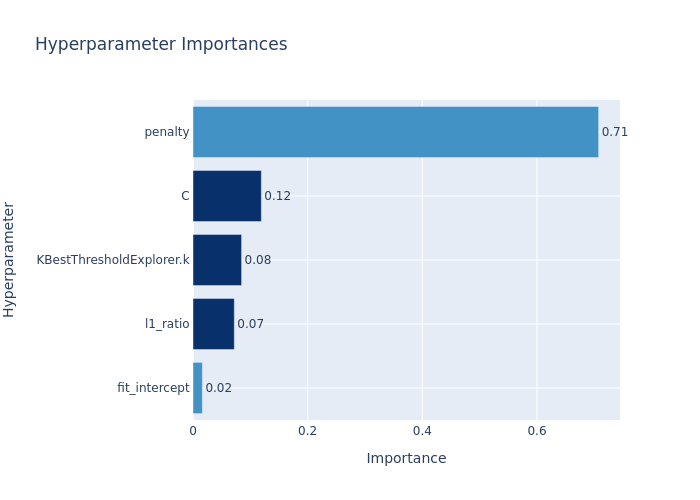

In [13]:
from IPython.display import Image

f = optuna.visualization.plot_param_importances(study)
Image(f.to_image(format="png", engine='kaleido'))

The following is a slice plot to better understand the parameter relationships. We see how the change in the parameter affects the performance of the model.

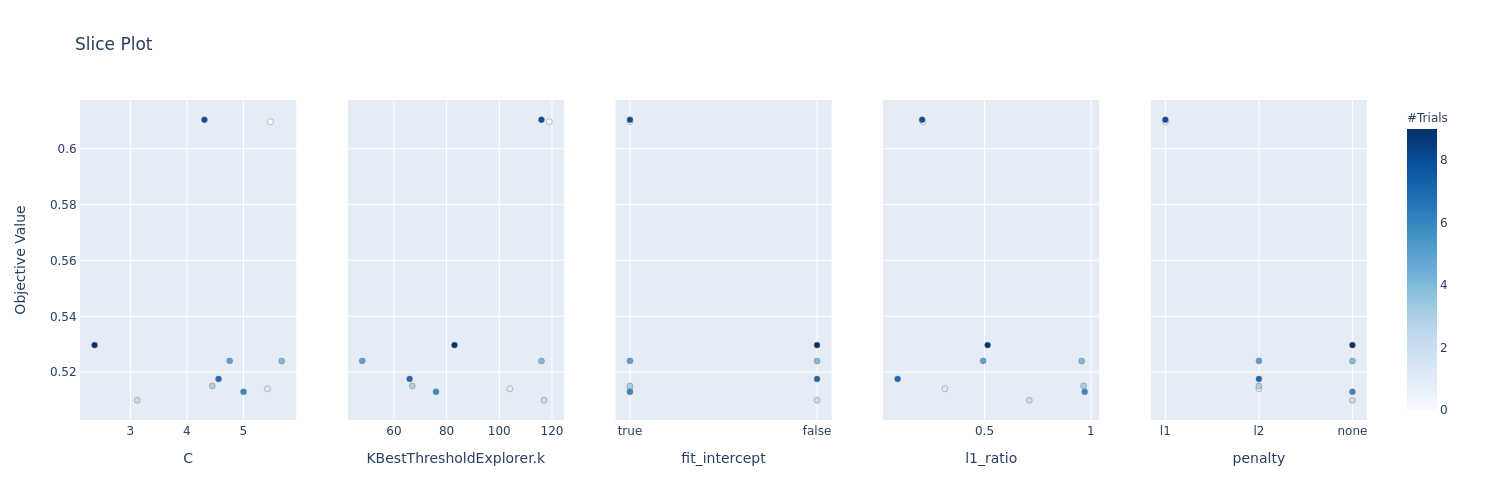

In [14]:
f = optuna.visualization.plot_slice(study, params=['l1_ratio', 'C', 'KBestThresholdExplorer.k', 'penalty', 'fit_intercept'])
Image(f.to_image(format="png", engine='kaleido'))

Let's plot the history of all trials in the study to see how the performance improvements took place within the study

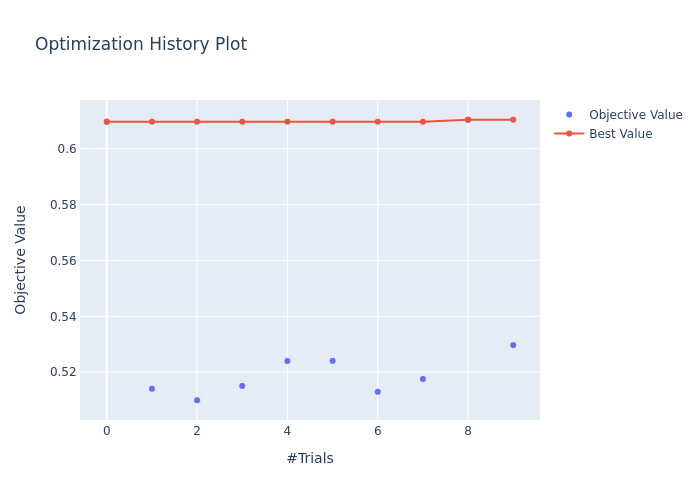

In [15]:
f = optuna.visualization.plot_optimization_history(study)
Image(f.to_image(format="png", engine='kaleido'))

Now, that we have seen the performance improvement, let's look at how we can retrieve this model with MLFlow.

### Launch our optimized model within the MLflow framework.
Run the code block below to identify the most recently registered model, with the 'rapids-optuna-airline' tag; after identifying the latest model version, run the code below in a separate terminal, and wait for it to fully load your model.

In [16]:
print(f"Run the command below in a terminal, and wait for it to load your model:\n\n  \
      {get_latest_mlflow_model(MLFLOW_TRACKING_URI, MLFLOW_MODEL_ID)}")

NameError: name 'get_latest_mlflow_model' is not defined

You should see output similar to the following:

```shell
2020/07/27 13:59:49 INFO mlflow.models.cli: Selected backend for flavor 'python_function'
2020/07/27 13:59:49 INFO mlflow.pyfunc.backend: === Running command 'source /anaconda3/bin/../etc/profile.d/conda.sh && conda activate mlflow-3335621df6011b1847d2555b195418d4496e5ffd 1>&2 && gunicorn --timeout=60 -b 127.0.0.1:5000 -w 1 ${GUNICORN_CMD_ARGS} -- mlflow.pyfunc.scoring_server.wsgi:app'
[2020-07-27 13:59:50 -0600] [23779] [INFO] Starting gunicorn 20.0.4
[2020-07-27 13:59:50 -0600] [23779] [INFO] Listening at: http://127.0.0.1:5000 (23779)
[2020-07-27 13:59:50 -0600] [23779] [INFO] Using worker: sync
[2020-07-27 13:59:50 -0600] [23788] [INFO] Booting worker with pid: 23788
```

In [ ]:
host='localhost'
port='56767'

headers = {
    "Content-Type": "application/json",
    "format": "pandas-split"
}

data = { 
    "columns": ["Year", "Month", "DayofMonth", "DayofWeek", "CRSDepTime", "CRSArrTime", "UniqueCarrier",
                "FlightNum", "ActualElapsedTime", "Origin", "Dest", "Distance", "Diverted"],
    "data": [[1987, 10, 1, 4, 1, 556, 0, 190, 247, 202, 162, 1846, 0]]
}

while (True):
    try:
        resp = requests.post(url="http://%s:%s/invocations" % (host, port), data=json.dumps(data), headers=headers)
        print('Classification: %s' % ("ON-Time" if resp.text == "[0.0]" else "LATE"))
        break
    except Exception as e:
        errmsg = "Caught exception attempting to call model endpoint: %s" % e
        print(errmsg)
        print("... Sleeping ...")
        time.sleep(20)

## Additional Resources
[How to Win a DS Kaggle competition](https://www.coursera.org/learn/competitive-data-science)

[Target Encoding and Bayesian Target Encoding](https://towardsdatascience.com/target-encoding-and-bayesian-target-encoding-5c6a6c58ae8c)

[Learn more about using MLFlow with RAPIDS](https://github.com/mlflow/mlflow/tree/master/examples/rapids/mlflow_project)
